In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta
from datetime import datetime  
from dateutil.parser import parse

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# retrieving column info from the tables
inspector = inspect(engine)
columns_m = inspector.get_columns('measurement')
columns_s = inspector.get_columns('station')
for c in columns_m:
    print(c['name'], c["type"])
print("------------")
for c in columns_s:
    print(c['name'], c["type"])
# Alternatively - 
# from sqlalchemy import MetaData
# m = MetaData()
# m.reflect(engine)
# for table in m.tables.values():
#     print("--------------")
#     print(table.name)
#     for column in table.c:
#         print(column.name,column.type)

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Sandbox for Flask
results=session.query(Station.station,Station.name).all()
results

[('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00513117', 'KANEOHE 838.1, HI US'),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00517948', 'PEARL CITY, HI US'),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00519281', 'WAIHEE 837.5, HI US'),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US')]

In [12]:
measurement_df=pd.DataFrame(session.query(Measurement.id, Measurement.station,Measurement.date, Measurement.prcp, Measurement.tobs).all())
measurement_df.tail()

,id,station,date,prcp,tobs
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0
19549,19550,USC00516128,2017-08-23,0.45,76.0


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
ini_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
ini_date_time = dt.datetime.strptime(ini_date[0],'%Y-%m-%d')
past_date_12mths = ini_date_time + timedelta(days=-365.5)
ini_date_time,past_date_12mths

(datetime.datetime(2017, 8, 23, 0, 0), datetime.datetime(2016, 8, 22, 12, 0))

In [14]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
prec_p12m=pd.DataFrame(session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= past_date_12mths).all())
prec_p12m_df=prec_p12m.set_index('date').sort_values('date')
prec_p12m_df

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


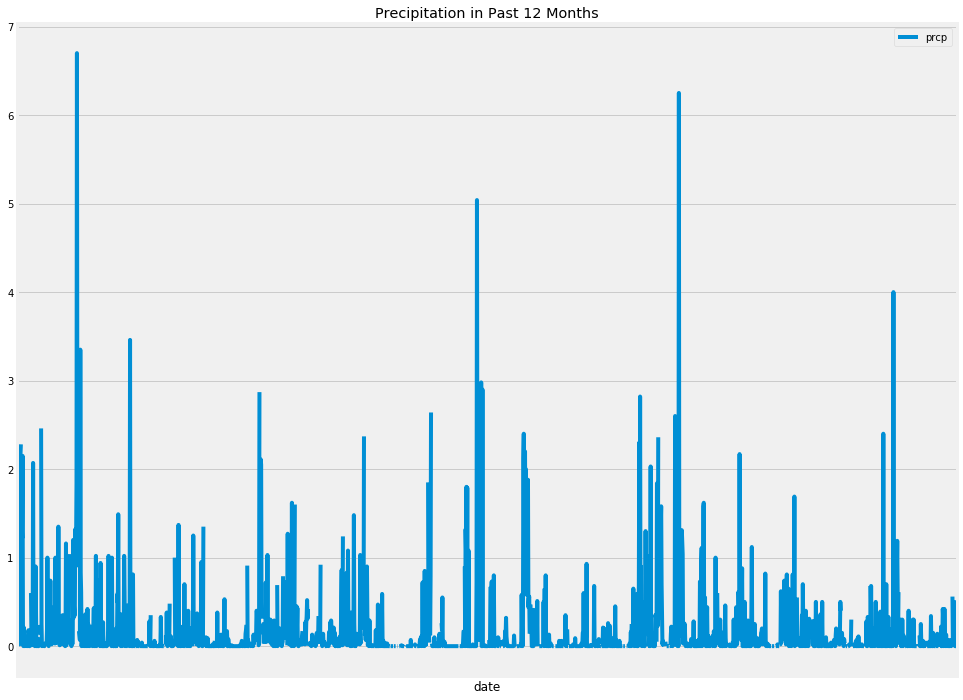

In [15]:
prec_p12m_df.plot(title='Precipitation in Past 12 Months',figsize=[15,12],legend=True,xticks=[])

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_p12m_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [17]:
# Design a query to show how many stations are available in this dataset?
measurement_df=pd.DataFrame(session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp,Measurement.tobs))
measurement_df
station_number = measurement_df.station.nunique()
print(f"There are {station_number} stations available in the dataset.")

There are 9 stations available in the dataset.


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
measurement_df.station.value_counts().sort_values(ascending=False)

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature of the most active station?
lowest_temp=session.query(func.min(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
highest_temp=session.query(func.max(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
avg_temp=session.query(func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
print(f"The most active station is USC00519281.")
print(f"The lowest temperaturer recorded is {lowest_temp[0][0]}.")
print(f"The highest temperature recorded is {highest_temp[0][0]}.")
print(f"The average temperature recorded is {avg_temp[0][0]}.")


The most active station is USC00519281.
The lowest temperaturer recorded is 54.0.
The highest temperature recorded is 85.0.
The average temperature recorded is 71.66378066378067.


In [20]:
# Alternatively:
# print(session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).all())

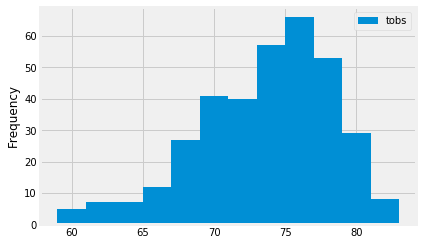

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_stn_df=pd.DataFrame(session.query(Measurement.station, Measurement.tobs).filter(Measurement.station=='USC00519281').filter(Measurement.date >= past_date_12mths).all())
most_active_stn_df.plot(kind='hist',bins=12)

## Optional Challenge Assignment

## Temperature Analysis I

- Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

- You may either use SQLAlchemy or pandas's read_csv() to perform this portion.

- Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

- Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [53]:
from scipy import stats

In [54]:
month_str_6 = "06"
month_str_12 = "12"
avg_6=session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m",Measurement.date)==month_str_6).all()
avg_12=session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m",Measurement.date)==month_str_12).all()
avg_6,avg_12

([(74.94411764705882)], [(71.04152933421226)])

In [55]:
all_temps_6=session.query(Measurement.tobs).filter(func.strftime("%m",Measurement.date)==month_str_6).all()
all_temps_12=session.query(Measurement.tobs).filter(func.strftime("%m",Measurement.date)==month_str_12).all()

In [56]:
# Unpaired t-test, as the temperatures are not related to each other, and also the 2 arrays have different number of values.
t,p=stats.ttest_ind(all_temps_6, all_temps_12,equal_var=False)
print(f"t = {t}"), print(f"p = {p}")

t = [31.35503692]
p = [4.19352984e-187]


(None, None)

In [57]:
# Conclusion -
if p <= 0.05:
    print(f"The temperatures in June and December have significant difference with a p-value of {p}, smaller than 0.05.")
else:
    print(f"The temperatures in June and December do NOT have significant difference with a p-value of {p}, higher than 0.05.")

The temperatures in June and December have significant difference with a p-value of [4.19352984e-187], smaller than 0.05.


## Optional Query Challenge - Temperature Analysis II

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
print(calc_temps('2017-02-02',ini_date_time))

[(58.0, 74.88907422852377, 87.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax for your trip using the previous year's data for those same dates.
print(calc_temps(past_date_12mths,ini_date_time))

[(58.0, 74.59058295964125, 87.0)]


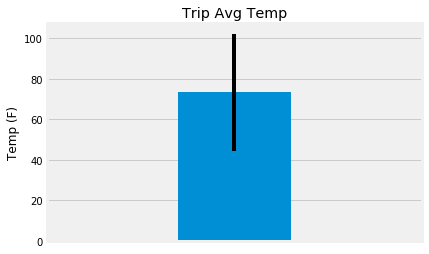

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_data_1 = pd.DataFrame(calc_temps(past_date_12mths,ini_date_time)[0],columns=['Temperature'])
yerror=trip_data_1.Temperature[2]-trip_data_1.Temperature[0]

plt.bar(x=0.5,height=trip_data_1.Temperature.mean(),yerr=yerror,width=0.3)
plt.title("Trip Avg Temp")
plt.xlim(0,1)
plt.xticks([])
plt.ylabel("Temp (F)")
plt.show()

## Daily Rainfall Averages

In [52]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel=[Measurement.station,func.sum(Measurement.prcp),Station.name,Station.latitude,Station.longitude,Station.elevation]
prep_stn_join=session.query(*sel).\
                filter(Measurement.station==Station.station).\
                filter(Measurement.date >= past_date_12mths).\
                group_by(Measurement.station).\
                order_by(func.sum(Measurement.prcp).desc()).all()

for record in prep_stn_join:
    (Measurement_station, Measurement.prcp,Station_name,Station_latitude,Station_longitude,Station_elevation)=record
    print(record)

('USC00519397', 1656.9899999999911, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00519281', 1615.6799999999919, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00516128', 1601.9099999999921, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00513117', 1574.3699999999926, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00519523', 1546.829999999993, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00514830', 1399.9499999999957, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00517948', 839.970000000001, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [89]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates

trip_start_date="2020-07-01"
trip_end_date="2020-07-10"
trip_start_dt=dt.datetime.strptime(trip_start_date,"%Y-%m-%d")
trip_end_dt=dt.datetime.strptime(trip_end_date,"%Y-%m-%d")
dates_generated = [trip_start_dt + dt.timedelta(days=x) for x in range(0, (trip_end_dt-trip_start_dt).days)]
dates_generated

[datetime.datetime(2020, 7, 1, 0, 0),
 datetime.datetime(2020, 7, 2, 0, 0),
 datetime.datetime(2020, 7, 3, 0, 0),
 datetime.datetime(2020, 7, 4, 0, 0),
 datetime.datetime(2020, 7, 5, 0, 0),
 datetime.datetime(2020, 7, 6, 0, 0),
 datetime.datetime(2020, 7, 7, 0, 0),
 datetime.datetime(2020, 7, 8, 0, 0),
 datetime.datetime(2020, 7, 9, 0, 0)]

In [84]:
# Stip off the year and save a list of %m-%d strings
dates_stipped = [dt.date.strftime(x,"%m-%d") for x in dates_generated]
dates_stipped

['07-01',
 '07-02',
 '07-03',
 '07-04',
 '07-05',
 '07-06',
 '07-07',
 '07-08',
 '07-09']

In [135]:
# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals_list=[daily_normals(date) for date in dates_stipped]
daily_normals_list

[[(67.0, 74.77777777777777, 81.0)],
 [(68.0, 75.40384615384616, 82.0)],
 [(68.0, 75.32075471698113, 87.0)],
 [(70.0, 76.57142857142857, 81.0)],
 [(66.0, 75.0, 81.0)],
 [(69.0, 75.0, 81.0)],
 [(69.0, 74.91071428571429, 82.0)],
 [(69.0, 76.08333333333333, 83.0)],
 [(68.0, 76.19298245614036, 83.0)]]

In [106]:
tmin_list=[]
tavg_list=[]
tmax_list=[]
for x in range(0,len(daily_normals_list)):
    (tmin,tavg,tmax)=daily_normals_list[x][0]
    tmin_list.append(tmin)
    tavg_list.append(tavg)
    tmax_list.append(tmax)

([67.0, 68.0, 68.0, 70.0, 66.0, 69.0, 69.0, 69.0, 68.0],
 [74.77777777777777,
  75.40384615384616,
  75.32075471698113,
  76.57142857142857,
  75.0,
  75.0,
  74.91071428571429,
  76.08333333333333,
  76.19298245614036],
 [81.0, 82.0, 87.0, 81.0, 81.0, 81.0, 82.0, 83.0, 83.0])

In [121]:
daily_normals_converted = [dates_stipped,tmin_list, tavg_list, tmax_list]
daily_normals_converted

[['07-01',
  '07-02',
  '07-03',
  '07-04',
  '07-05',
  '07-06',
  '07-07',
  '07-08',
  '07-09'],
 [67.0, 68.0, 68.0, 70.0, 66.0, 69.0, 69.0, 69.0, 68.0],
 [74.77777777777777,
  75.40384615384616,
  75.32075471698113,
  76.57142857142857,
  75.0,
  75.0,
  74.91071428571429,
  76.08333333333333,
  76.19298245614036],
 [81.0, 82.0, 87.0, 81.0, 81.0, 81.0, 82.0, 83.0, 83.0]]

In [146]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df_1=pd.DataFrame(daily_normals_converted,index=['date','tmin','tavg','tmax'])
trip_df_1
trip_df=pd.DataFrame.transpose(trip_df_1).set_index('date')
trip_df

,tmin,tavg,tmax
date,,,
07-01,67,74.7778,81
07-02,68,75.4038,82
07-03,68,75.3208,87
07-04,70,76.5714,81
07-05,66,75,81
07-06,69,75,81
07-07,69,74.9107,82
07-08,69,76.0833,83
07-09,68,76.193,83


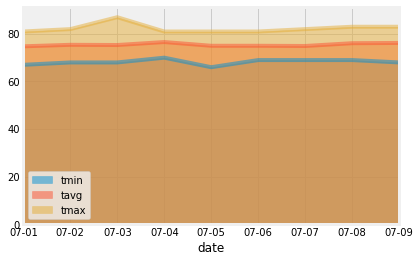

In [149]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot(kind='area',stacked=False,legend=True)